# Deep Neural Network for MNIST Classification

## Import the relevant packages

In [1]:
import io
import itertools
import datetime

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [2]:
# It's a best practise to define some constants/hyperparameters in a visible place

max_epochs = 20
batch_size = 128 # A value that's a power of 2
steps_per_epoch = 100
output_size = 10

## Data

### Load the data from keras.datasets

In [3]:
mnist_dataset = keras.datasets.mnist.load_data()
mnist_train, mnist_test = mnist_dataset

### Scaling

In [4]:
scaled_train_inputs, train_targets = mnist_train[0] / 255., mnist_train[1]
scaled_test_inputs, test_targets = mnist_test[0] / 255., mnist_test[1]

### Shuffling

In [5]:
#train data
shuffled_indices = np.arange(scaled_train_inputs.shape[0])
np.random.shuffle(shuffled_indices)

shuffled_train_inputs, shuffled_train_targets = scaled_train_inputs[shuffled_indices], train_targets[shuffled_indices]

#test data
shuffled_indices = np.arange(scaled_test_inputs.shape[0])
np.random.shuffle(shuffled_indices)

shuffled_test_inputs, shuffled_test_targets = scaled_test_inputs[shuffled_indices], test_targets[shuffled_indices]

### Create validation data 

In [6]:
num_validation_samples = int(0.1 * shuffled_train_inputs.shape[0])

train_inputs = shuffled_train_inputs[num_validation_samples:].reshape((-1, 28, 28, 1))
train_targets = shuffled_train_targets[num_validation_samples:]

validation_inputs = shuffled_train_inputs[:num_validation_samples].reshape((-1, 28, 28, 1))
validation_targets = shuffled_train_targets[:num_validation_samples]

test_inputs, test_targets = shuffled_test_inputs.reshape((-1, 28, 28, 1)), shuffled_test_targets

print(train_inputs.shape)

(54000, 28, 28, 1)


## Outline the model 

In [7]:
model = keras.Sequential([
    keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)), # the stride is 2 by default
    keras.layers.Conv2D(50, 3, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(output_size)
])


In [8]:
model.summary(line_length = 100)

Model: "sequential"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
conv2d (Conv2D)                              (None, 24, 24, 50)                      1300           
____________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)                 (None, 12, 12, 50)                      0              
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                            (None, 10, 10, 50)                      22550          
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)               (None, 5, 5, 50)                        0              
_______________________________________________________________________

### Choose the optimizer and the loss function

In [9]:
# Defining the loss function

# In general, our model needs to output probabilities of each class, 
# which can be achieved with a softmax activation in the last dense layer

# However, when using the softmax activation, the loss can rarely be unstable

# Thus, instead of incorporating the softmax into the model itself,
# we use a loss calculation that automatically corrects for the missing softmax

# That is the reason for 'from_logits=True'
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [10]:
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

### Training

#### Logging the training process data to use later in tensorboard

In [11]:
# The logging directory
log_dir = 'logs\\fit\\' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

# Log the confusion matrix as an image

def plot_confusion_matrix(cm, class_names, normalized=True):
    
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(12, 12))
    
    # Plot the image
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    
    # Plot the bar color associated with the image
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))
    # class_names are the labels to place at the given ticks locations.
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    
    # Normalize the confusion matrix.
    if not normalized:
        # cm.sum(axis=1)[:, np.newaxis] : reshapes the vector (1D array) to a matrix (2D array)
        # It's the same as : cm.sum(axis=1, keepdims=True)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    cm = np.around(cm.astype('float'), decimals=2)


    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    # Product of {0-9} * {0-9} = {(0, 0), (0, 1)...}
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

        
    plt.tight_layout() # Adjust the padding
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

def plot_to_image(figure):
    """Converts the matplotlib plot specified with 'figure' to a PNG image and returns it,
    The supplied figure is closed and inaccessible after this call.
    """
    
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close()
    
    # Convert the PNG buffer to TF image.
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Add the batch dimension.
    image = tf.expand_dims(image, 0)
    
    return image

# Logging the cm's image to tensorboard

# Define a file writer variable for the logging purposes
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

# The lambda callback to be called should have the (epoch, logs) parameters
def log_confusion_matrix(epoch, logs):
    
    # Use the model to predict the values from the validation dataset.
    predictions_raw = model.predict(validation_inputs)

    # np.argmax() returns the index of the maximum value of an array (in our case the classe with the highest probability).
    # NB: also np.argmin() returns the index of minimum
    predictions = np.argmax(predictions_raw, axis=1)

    # Calculate the confusion matrix from the sklearn.metrics
    # Notice that the matrix is normalized
    cm = confusion_matrix(validation_targets, predictions, normalize='true')

    # Log the confusion matrix as an image.
    
    figure = plot_confusion_matrix(cm, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], True)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image('Confusion Matrix', cm_image, step=epoch)
        

In [12]:
# The tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)

# The confusion matrix callback
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

#### The training process

In [13]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='auto',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

In [14]:
history = model.fit(
    train_inputs,
    train_targets,
    
    # NB: We can specify the steps_per_epoch instead of the batch_size
    # n_samples = steps_per_epoch * batch_size
    #steps_per_epoch=steps_per_epoch,
    batch_size=batch_size,
    
    epochs=max_epochs,
    
    # NB: the early_stopping callback should always be the last element in the list
    callbacks=[tensorboard_callback, cm_callback, early_stopping],
    
    validation_data=(validation_inputs, validation_targets),
    verbose=2
)

Epoch 1/20
422/422 - 40s - loss: 0.2622 - accuracy: 0.9243 - val_loss: 0.0852 - val_accuracy: 0.9743
Epoch 2/20
422/422 - 38s - loss: 0.0708 - accuracy: 0.9789 - val_loss: 0.0573 - val_accuracy: 0.9818
Epoch 3/20
422/422 - 38s - loss: 0.0514 - accuracy: 0.9841 - val_loss: 0.0474 - val_accuracy: 0.9843
Epoch 4/20
422/422 - 38s - loss: 0.0417 - accuracy: 0.9869 - val_loss: 0.0383 - val_accuracy: 0.9882
Epoch 5/20
422/422 - 38s - loss: 0.0347 - accuracy: 0.9899 - val_loss: 0.0389 - val_accuracy: 0.9867
Epoch 6/20
422/422 - 38s - loss: 0.0293 - accuracy: 0.9911 - val_loss: 0.0309 - val_accuracy: 0.9893
Epoch 7/20
422/422 - 38s - loss: 0.0258 - accuracy: 0.9919 - val_loss: 0.0335 - val_accuracy: 0.9877
Epoch 8/20
422/422 - 38s - loss: 0.0237 - accuracy: 0.9925 - val_loss: 0.0309 - val_accuracy: 0.9900


### Visualizing with Matplotlib

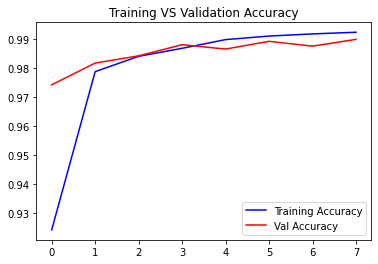

In [15]:
# We can use our variable history
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure()
plt.plot(epochs, accuracy, 'blue', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'red', label='Val Accuracy')
plt.title('Training VS Validation Accuracy')
plt.legend()
plt.show()

### Visualizing with TensorBoard

In [17]:
# Loading the TensorBoard extension
%load_ext tensorboard

# Loading the logged data that TensorBoard for visualizing the training process
%tensorboard --logdir 'logs/fit'

# On windows we should to kill the task and clear the temporary data used by tensorboard with the commands:

# taskkill /im tensorboard.exe /f
# del /q %TMP%\.tensorboard-info\*

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2292), started 0:01:10 ago. (Use '!kill 2292' to kill it.)

## Test the model

In [18]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

313/313 [==============================] - 2s 7ms/step - loss: 0.0275 - accuracy: 0.9910


In [19]:
print('\nTest loss: {0:.2f}, Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))


Test loss: 0.03, Test accuracy: 99.10%


### Plot some test images with the corresponding labels

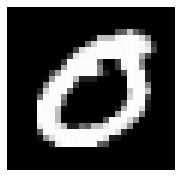

Label: 0


In [20]:
test_images = test_inputs.reshape((-1, 28, 28))
test_labels = test_targets

# an arbitrary chosen image
i = 183

plt.figure(figsize=(3, 3))
plt.axis('off')
plt.imshow(test_images[i], cmap='gray', aspect='auto')
plt.show()

print('Label: {}'.format(test_labels[i]))

### Plot the model predictions

<BarContainer object of 10 artists>

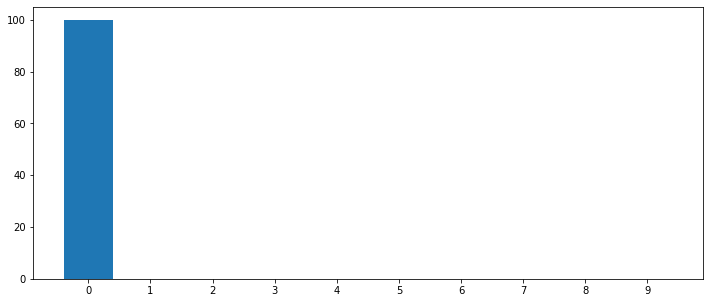

In [21]:
# Obtain the model's predictions (logits)
predictions = model.predict(test_inputs[i: i+1])

# Convert the predictions into probabilities (recall that we incorporated the softmax activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy() * 100 # .numpy() to convert the probabilities into a numpy array

# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12, 5))
plt.bar(x=[0,1,2,3,4,5,6,7,8,9], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])